In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import itertools
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import utils
from utils import laion_utils as laionu
from utils import wordnet_utils as wnu
from utils.calc_utils import calc_recall_per_y
from core.ilsvrc_predictors import all_model_names_1k, all_model_names_pt21k_ft1k, all_model_names_21k
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

## Filtering

In [4]:
q_type = QueryType.NAME_DEF
q_key = 'wnid'
text_encoder_ver = configs.CLIPConfig.DEFAULT_VERSION
# text_encoder_ver = 'all-mpnet-base-v2'

query_col = q_type + '_' + q_key
text_query_sim_col = f'text_to_{query_col}_similarity_{text_encoder_ver}'

print(text_query_sim_col)

text_to_name_def_wnid_similarity_clip-vit-base-patch32


## Path

### LAIONet

In [5]:
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)

do_skim = False
if do_skim:
    laionet_prefix = configs.NamingConfig.append_skimmed(laionet_prefix)

laionet_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)

print(laionet_file_name)

# Labels
laionet_labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
laionet_labels_file_name = f'wnid2laionindices({laionet_prefix}).pkl'

subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet


### ILSVRC val

In [6]:
ilsvrc_path = 'ilsvrc2012'

ilsvrc_val_prefix = 'ILSVRC2012_val'

ilsvrc_val_file_name = ilsvrc_val_prefix + '.parquet'

# Labels
ilsvrc_val_labels_file_path = os.path.join(ilsvrc_path, 'processed', 'labels', 'imagename2wnid.pkl')

## Other

In [7]:
top_k_col = lambda k, mdl: f'top_{k}_is_correct_{mdl}'
rec_text_is_in_col = f'wnid_is_in_recognized_text'

## Models

In [8]:
model_names = all_model_names_1k + all_model_names_pt21k_ft1k + all_model_names_21k

# model_names.append(configs.CLIPConfig.DEFAULT_VERSION)

print('\n'.join(model_names))

resnet-18
resnet-34
resnet-50
resnet-101
resnet-152
convnext-tiny-224
convnext-small-224
convnext-base-224
convnext-large-224
convnext-base-384
convnext-large-384
vit-base-patch16-224
vit-base-patch16-384
vit-base-patch32-384
vit-large-patch16-224
vit-large-patch16-384
vit-large-patch32-384
convnext-base-224-22k-1k
convnext-large-224-22k-1k
convnext-base-384-22k-1k
convnext-large-384-22k-1k
beit-base-patch16-224
beit-base-patch16-384
beit-large-patch16-224
beit-large-patch16-384
convnext-base-224-22k
convnext-large-224-22k
beit-base-patch16-224-pt22k-ft22k
beit-large-patch16-224-pt22k-ft22k


In [9]:
modelname2color = {}

for model_name in all_model_names_1k:
    modelname2color[model_name] = 'r'

for model_name in all_model_names_pt21k_ft1k:
    modelname2color[model_name] = 'y'
    
for model_name in all_model_names_21k:
    modelname2color[model_name] = 'g'
    
modelname2color[configs.CLIPConfig.DEFAULT_VERSION] = 'k'

# Load

## LAIONet

In [10]:
df = pd.read_parquet(
    os.path.join(laion_path, laionet_file_name)
)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,...,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k,wnid_is_in_recognized_text
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,drum which is a musical percussion instrument;...,0.853099,...,True,True,True,True,True,True,True,True,True,False
2176,3.572065e+12,https://i0.wp.com/www.paginascanarias.com/wp-c...,barbershop triana,200.0,200.0,?,UNLIKELY,0.318373,barbershop which is a shop where men can get t...,0.827356,...,True,False,True,False,True,False,True,False,True,False
3188,2.178581e+12,http://static11.zobazo.com/USA/2018//2694/4320...,Four marmoset monkey available for sale (male ...,160.0,135.0,?,UNLIKELY,0.358621,marmoset which is small soft-furred South Amer...,0.824072,...,None,None,None,None,None,None,None,None,None,False


## ILSVRC val

In [13]:
ilsvrc_val_df = pd.read_parquet(os.path.join(ilsvrc_path, ilsvrc_val_file_name))

print(ilsvrc_val_df.shape)

ilsvrc_val_df.tail(3)

(50000, 61)


,name_def_wnid,top_1_is_correct_clip-vit-base-patch32,top_5_is_correct_clip-vit-base-patch32,top_1_is_correct_resnet-18,top_5_is_correct_resnet-18,top_1_is_correct_resnet-34,top_5_is_correct_resnet-34,top_1_is_correct_resnet-50,top_5_is_correct_resnet-50,top_1_is_correct_resnet-101,...,top_1_is_correct_convnext-large-384,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k
ILSVRC2012_val_00049998.JPEG,border collie which is developed in the area b...,True,True,True,True,True,True,False,True,True,...,False,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00049999.JPEG,groom which is a man participant in his own ma...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00050000.JPEG,llama which is wild or domesticated South Amer...,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Labels

In [14]:
with open(os.path.join(laionet_labels_path, laionet_labels_file_name), 'rb') as f:
    wnid2laionindices = pickle.load(f)

In [15]:
with open(ilsvrc_val_labels_file_path, 'rb') as f:
    imagename2wnid = pickle.load(f)
    
# Find the inverse map
wnid2imagenames = utils.find_inverse_map(imagename2wnid)

# Calc. recall

In [16]:
tq_sim_th = 0.82  # 0.58

## LAIONet

In [17]:
df_filt = df[df[text_query_sim_col] > tq_sim_th]

topk2model2wnid2recall = {1: {}, 5: {}}
topk2model2wnid2recallse = {1: {}, 5: {}}

for k in [1, 5]:
    topk2model2wnid2recall[k], topk2model2wnid2recallse[k], _ = \
        calc_recall_per_y(df_filt, wnid2laionindices, model_names, k, drop_if_true_cols=[rec_text_is_in_col])

100%|█████████████████████████████████████████| 978/978 [04:20<00:00,  3.76it/s]


## ILSVRC val

In [18]:
projected_wnid2imagenames = {wnid: image_names for wnid, image_names in wnid2imagenames.items()
                           if wnid in wnid2laionindices}

In [19]:
topk2model2wnid2ilsvrcrecall = {1: {}, 5: {}}
topk2model2wnid2ilsvrcrecallse = {1: {}, 5: {}}

for k in [1, 5]:
    topk2model2wnid2ilsvrcrecall[k], topk2model2wnid2ilsvrcrecallse[k], _ = \
        calc_recall_per_y(ilsvrc_val_df, projected_wnid2imagenames, model_names, k)

100%|█████████████████████████████████████████| 977/977 [00:20<00:00, 46.57it/s]


# Relative frequency of the classes

## Load all labels (not skimmed)

In [20]:
all_laionet_prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)
all_laionet_labels_file_name = f'wnid2laionindices({all_laionet_prefix}).pkl'

with open(os.path.join(laionet_labels_path, all_laionet_labels_file_name), 'rb') as f:
    all_wnid2laionindices = pickle.load(f)

## Calc. stat.

In [21]:
n = np.sum([len(laion_indices) for _, laion_indices in all_wnid2laionindices.items()])

wnid2freq = {wnid: len(laion_indices) for wnid, laion_indices in all_wnid2laionindices.items() if len(laion_indices) > 0}

# Sort it by freq
wnid2freq = dict(sorted(wnid2freq.items(), key=lambda item: -item[1]))

# Find prob.
wnid2prob = {wnid: freq/n for wnid, freq in wnid2freq.items()}

In [22]:
wnids = list(wnid2freq.keys())

synsets = []
freqs = []
for wnid in wnids:
    synsets.append(wnu.get_synset(wnid).name().split('.n')[0])
    freqs.append(wnid2freq[wnid])

imagenet_tot = np.sum(freqs)

In [23]:
print('Out of roughly 400M LAION samples, %d (%.2f%%) of them have at least one ImageNet class.'
      % (imagenet_tot, imagenet_tot/4e8*100))

Out of roughly 400M LAION samples, 822149 (0.21%) of them have at least one ImageNet class.


# Accuracy vs. frequency

In [24]:
top_k = 1

In [25]:
chosen_model_names = [
    'resnet-50',
    'convnext-base-224',
    'convnext-base-224-22k-1k',
    'vit-base-patch16-224', 
]

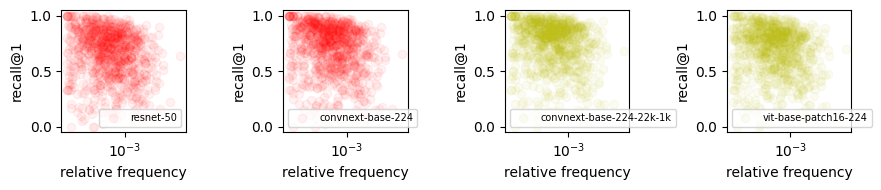

In [26]:
n_m = len(chosen_model_names)

plt.figure(figsize=(n_m*2.2, 2))

for i_m, model_name in enumerate(chosen_model_names):
    recalls = []
    probs = []
    for wnid, prob in wnid2prob.items():
        if wnid2freq[wnid] < 10:
            continue
        if wnid not in topk2model2wnid2recall[top_k][model_name]:
            continue
        recalls.append(topk2model2wnid2recall[top_k][model_name][wnid])
        probs.append(prob)
        
    plt.subplot(1, n_m, i_m + 1)
    cl = modelname2color[model_name]
    
    plt.plot(probs, recalls, 'o', alpha=0.05, color=cl)
    
    plt.legend([model_name], fontsize=7)
    plt.xlabel('relative frequency')
    plt.ylabel('recall@%d' % top_k)

    plt.xscale('log')
    
plt.tight_layout()

plt.savefig(os.path.join('figs', f'top%d_acc_vs_rel_freq_{all_laionet_prefix}.pdf' % top_k))

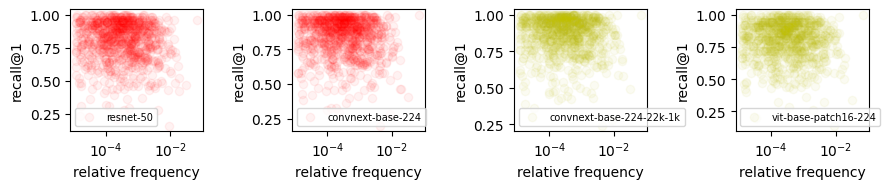

In [28]:
n_m = len(chosen_model_names)

plt.figure(figsize=(n_m*2.2, 2))

for i_m, model_name in enumerate(chosen_model_names):
    recalls = []
    probs = []
    for wnid, prob in wnid2prob.items():
        if wnid2freq[wnid] < 10:
            continue
        if wnid not in topk2model2wnid2ilsvrcrecall[top_k][model_name]:
            continue
        recalls.append(topk2model2wnid2ilsvrcrecall[top_k][model_name][wnid])
        probs.append(prob)
        
    plt.subplot(1, n_m, i_m + 1)
    cl = modelname2color[model_name]
    
    plt.plot(probs, recalls, 'o', alpha=0.05, color=cl)
    
    plt.legend([model_name], fontsize=7)
    plt.xlabel('relative frequency')
    plt.ylabel('recall@%d' % top_k)

    plt.xscale('log')
    
plt.tight_layout()

plt.savefig(os.path.join('figs', f'top%d_ilsvrc_acc_vs_rel_freq_{all_laionet_prefix}.pdf' % top_k))

# Accuracy vs. intra-class similarity

In [29]:
cross_image_sim_path = os.path.join(laion_path, 'processed', 'clip_image_similarities')

cross_image_sim_prefix = '_img_img_sims'

sim_key = 'similarities'

def vec(x):
    msk = np.tril(np.eye(len(x)) < 0.5)
    return x[msk]

## Load sims and find the average intra-class sim.

In [30]:
wnid2avglsim = {}
wnid2avgisim = {}
for wnid in tqdm(wnid2laionindices):
    l_sim_path = os.path.join(cross_image_sim_path, laionet_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    i_sim_path = os.path.join(cross_image_sim_path, 'imagenet_captions' + cross_image_sim_prefix + f'({wnid}).pkl')
    
    if (not os.path.exists(l_sim_path)) or (not os.path.exists(i_sim_path)):
        continue

    with open(l_sim_path, 'rb') as f:
        l_sim_dict = pickle.load(f)
    with open(i_sim_path, 'rb') as f:
        i_sim_dict = pickle.load(f)
        
    if (not isinstance(l_sim_dict, dict)):
        continue
        
    wnid2avglsim[wnid] = np.mean(vec(l_sim_dict[sim_key]))
    wnid2avgisim[wnid] = np.mean(vec(i_sim_dict[sim_key]))

100%|████████████████████████████████████████| 978/978 [00:03<00:00, 261.22it/s]


## Plot

In [31]:
top_k = 1

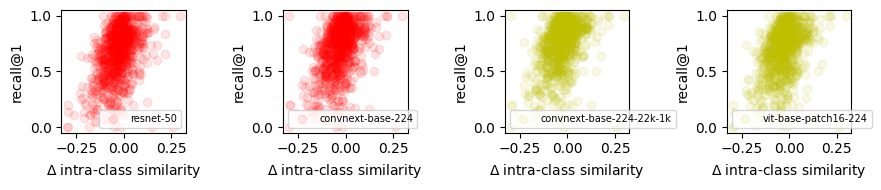

In [32]:
n_m = len(chosen_model_names)

plt.figure(figsize=(n_m*2.2, 2))

for i_m, model_name in enumerate(chosen_model_names):
    recalls = []
    sims = []
    for wnid, sim in wnid2avglsim.items():
        if wnid not in topk2model2wnid2recall[top_k][model_name]:
            continue
            
        recalls.append(topk2model2wnid2recall[top_k][model_name][wnid])
        sims.append(sim - wnid2avgisim[wnid])
        
    plt.subplot(1, n_m, i_m + 1)
    cl = modelname2color[model_name]
    
    plt.plot(sims, recalls, 'o', alpha=0.1, color=cl)
    
    plt.legend([model_name], fontsize=7)
    plt.xlabel(r'$\Delta$ intra-class similarity')
    plt.ylabel('recall@%d' % top_k)
    
plt.tight_layout()

plt.savefig(os.path.join('figs', f'top%d_acc_vs_intra-class_sim_{laionet_prefix}.pdf' % top_k))

# Intra-class similarity vs. frequency

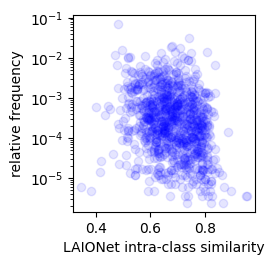

In [33]:
n_m = len(chosen_model_names)

plt.figure(figsize=(2.75, 2.75))

probs = []
sims = []
for wnid, sim in wnid2avglsim.items():
    probs.append(wnid2prob[wnid])
    sims.append(sim)

plt.plot(sims, probs, 'o', alpha=0.1, color='b')

plt.xlabel('LAIONet intra-class similarity')
plt.ylabel('relative frequency')

plt.yscale('log')
    
plt.tight_layout()

plt.savefig(os.path.join('figs', f'intra-class_sim_vs_rel_freq_{laionet_prefix}.pdf'))